# Recommender System(CSE4077)

## Fashion Recommender System(J Component)
 By: 
 
    Lokesh Kanna 19MIA1014
    Nithya Sharma 19MIA1028
    Yuvashree R 19MIA1053
    Niharika Samyuktha K 19MIA1083

Importing dataset from kaggle (https://www.kaggle.com/paramaggarwal/fashion-product-images-small)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lokeshkanna1014","key":"c56225344810139c9b0bf0675c7cd629"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          12087        383  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9669        296  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01           1047         25  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

100% 564M/565M [00:27<00:00, 21.0MB/s]
100% 565M/565M [00:27<00:00, 21.2MB/s]


In [ ]:
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/imag

In [ ]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
DATASET_PATH = "/content/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


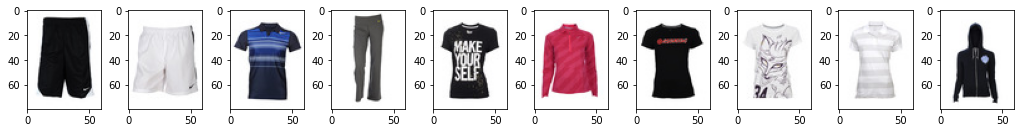

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/100'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

## Pre-processing

Merging the csv data with image data

In [ ]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

   year   usage                             productDisplayName      image  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016  Casual                         Skagen Men Black Watch  30039.jpg

Displaying count of every category of wearable/Clothing products

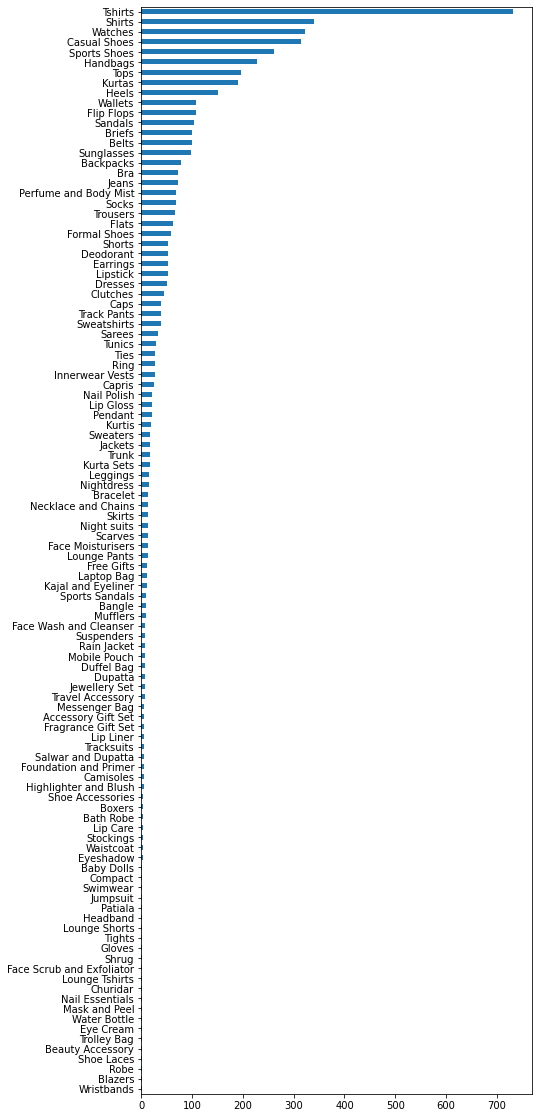

In [ ]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Model Building

Basically the input image and fashion dataset are put in the transfer learning models 
(Densenet161,vgg16,resnet50) as the base of the network and compared and once the features are 
learned from one problem it is then used to leverage them on a new similar problem.

In [ ]:
img_width, img_height, chnl = 200, 200, 3

## VGG Model

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(img_width, img_height, chnl))
vgg.trainable=False
model1 = keras.Sequential([vgg,GlobalMaxPooling2D()])
model1.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


## DenseNet Model

In [ ]:
#DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

model2 = keras.Sequential([densenet,GlobalMaxPooling2D()])

model2.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


## Resnet Model 

In [ ]:
#Resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, chnl))
resnet.trainable = False
model3 = keras.Sequential([resnet,GlobalMaxPooling2D()])

model3.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
def img_path(img):
    return DATASET_PATH + 'images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [ ]:
df_copy1      = df
df_embedding1 = df_copy1['image'].apply(lambda x: model_predict(model1, x))
df_embedding1 = df_embedding1.apply(pd.Series)
df_embedding1.head(5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step


0         1         2         3         4         5         6    \
0  1.519472  0.000000  0.907910  0.854202  0.436189  0.000000  2.312882   
1  0.934483  0.965172  0.895148  0.000000  0.826164  0.000000  0.550216   
2  2.385171  0.000000  1.618433  2.651848  0.368371  0.854072  2.842783   
3  0.036598  0.000000  0.275557  0.000000  1.499349  0.000000  1.280986   
4  1.008840  0.000000  1.670842  1.299989  0.858920  0.587321  2.472533   

        7         8         9    ...       502       503       504       505  \
0  2.807397  1.811290  0.000000  ...  1.962265  2.589481  0.143802  0.345058   
1  1.958884  0.657640  0.000000  ...  1.251365  4.443590  0.367616  1.104145   
2  0.055519  0.000000  1.645047  ...  1.648798  0.626699  0.642798  0.000000   
3  0.072011  0.000000  0.000000  ...  1.322175  4.268617  0.376121  0.606315   
4  1.357729  0.754673  0.000000  ...  1.609789  3.229031  0.413134  1.516540   

        506       507       508       509       510       511  
0  0.888529  0.957579  1.721579  0.138817  1.028795  0.000000  
1  0.348345  1.172423  1.727709  0.794590  2.051221  0.495932  
2  0.000000  1.018214  0.496337  0.000000  0.984315  0.000000  
3  0.472987  0.638497  1.457756  0.000000  0.703641  0.045587  
4  0.941913  0.634966  3.043238  0.450548  0.890278  0.080900  

[5 rows x 512 columns]

In [ ]:
df_copy2      = df
df_embedding2 = df_copy2['image'].apply(lambda x: model_predict(model2, x))
df_embedding2 = df_embedding2.apply(pd.Series)
df_embedding2.head(5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step


0         1         2         3         4         5         6     \
0  0.001453  0.007667  0.020786  0.017618  0.563271  1.813152  0.004163   
1  0.001270  0.033970  0.010328  0.018846  0.534164  1.102736  0.001283   
2  0.001749  0.009188  0.014582  0.007122  0.568848  1.369894  0.002457   
3  0.000788  0.019114  0.013595  0.017823  0.529423  2.502741  0.001060   
4  0.001572  0.012700  0.014415  0.014550  0.431778  1.308465  0.002086   

       7         8         9     ...      1014      1015       1016      1017  \
0  0.009205  1.286595  0.001648  ...  2.046627  0.712431  16.476810  0.743846   
1  0.009292  1.386438  0.000774  ...  0.351498  6.866690  10.786267  6.283558   
2  0.003840  0.607828  0.000701  ...  2.888709  7.010256   4.313007  1.585574   
3  0.010470  1.192753  0.001702  ...  0.276016  0.000000  14.582164  4.909027   
4  0.011448  1.112463  0.001078  ...  0.312273  1.817061  15.469989  3.959401   

       1018      1019      1020      1021       1022      1023  
0  0.915041  0.888128  4.459033  2.630814   6.901199  4.310223  
1  2.486135  4.042778  6.910799  0.906806   2.356669  1.481576  
2  3.094147  0.225649  7.055234  4.394608  16.545847  1.425267  
3  0.243700  4.130847  2.814886  0.500820   0.626906  1.440793  
4  0.000000  0.694539  3.778365  6.004065   2.014088  2.263580  

[5 rows x 1024 columns]

In [ ]:
df_copy3     = df
df_embedding3 = df_copy3['image'].apply(lambda x: model_predict(model3, x))
df_embedding3 = df_embedding3.apply(pd.Series)
df_embedding3.head(5)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


0         1         2         3         4     5         6        7     \
0  0.000000  0.686043  0.180532  1.105286  3.582012   0.0  4.561825  0.00000   
1  0.089979  0.985389  0.000000  2.582207  5.242706   0.0  3.190972  0.00000   
2  0.000000  1.686468  0.093102  1.408281  2.792996   0.0  3.678902  0.00000   
3  0.000000  0.493862  0.000000  4.835561  7.473870   0.0  3.079211  0.83264   
4  0.000000  2.259151  0.000000  2.643829  2.568402   0.0  3.929414  0.00000   

       8         9     ...      2038      2039      2040      2041      2042  \
0  3.665304  0.162952  ...  1.592935  0.000000  3.181750  0.000000  1.166895   
1  1.402244  0.000000  ...  2.403221  0.000000  1.766771  0.000000  0.000000   
2  2.619772  0.000000  ...  2.088865  0.000000  0.000000  0.000000  0.000000   
3  2.922193  0.000000  ...  1.937649  2.411925  1.450243  0.000000  0.000000   
4  2.264767  0.000000  ...  3.268199  0.217566  2.145493  1.633705  0.040632   

       2043     2044      2045      2046      2047  
0  3.673205  0.00000  8.973462  3.534076  0.942976  
1  2.785163  0.00000  6.062478  5.397768  0.449313  
2  0.000000  0.00000  9.980750  2.049756  0.000000  
3  2.124938  0.75314  7.835526  6.929082  1.029547  
4  1.223841  0.00000  9.307403  8.296400  0.000000  

[5 rows x 2048 columns]

In [ ]:
print(df_embedding1.shape) #VGG16
print(df_embedding2.shape) #Densenet121
print(df_embedding3.shape) #Resnet50

(5000, 512)
(5000, 1024)
(5000, 2048)


In [ ]:
url="/content/S2.jpg"

### Test Image

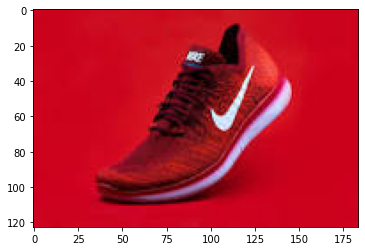

In [ ]:
a = plt.imread(url)
plt.imshow(a)

## Model Prediction 

In [ ]:
def model_predict(model, url):
     # Reshape
     img = image.load_img(url, target_size=(img_width, img_height))
     # img to Array
     x   = image.img_to_array(img)
     # Expand Dim (1, w, h)
     x   = np.expand_dims(x, axis=0)
     # Pre process Input
     x   = preprocess_input(x)
     return model.predict(x)

In [ ]:
df_vgg=model_predict(model1, url)
df_dn=model_predict(model2, url)
df_rn=model_predict(model3, url)

1/1 [==============================] - 0s 34ms/step


In [ ]:
print(df_vgg)
print(df_vgg.shape)
print(df_dn)
print(df_dn.shape)
print(df_rn)
print(df_rn.shape)

[[1.15267599e+00 9.32772160e-02 2.11139965e+00 0.00000000e+00
  9.43457425e-01 0.00000000e+00 7.55313709e-02 0.00000000e+00
  5.21697998e-01 5.56765509e+00 0.00000000e+00 6.23515725e-01
  1.15190935e+00 0.00000000e+00 5.86292073e-02 1.12568879e+00
  1.38955069e+00 1.33328652e+00 5.64019680e-02 0.00000000e+00
  3.23018402e-01 7.68294930e-01 4.98255163e-01 0.00000000e+00
  5.45193672e-01 0.00000000e+00 2.22375488e+00 1.89802003e+00
  0.00000000e+00 6.95048571e-01 1.35097480e+00 1.12924004e+00
  2.59994435e+00 3.44518065e-01 5.65611899e-01 1.01616800e+00
  1.12537622e+00 5.11354148e-01 0.00000000e+00 0.00000000e+00
  2.89281309e-01 0.00000000e+00 1.53452373e+00 0.00000000e+00
  8.16150248e-01 3.03608227e+00 1.02330697e+00 1.41232061e+00
  8.14615250e-01 1.57397473e+00 5.79773128e-01 3.14168394e-01
  6.87740207e-01 1.06194115e+00 1.90331566e+00 1.61435628e+00
  1.54008543e+00 9.22331214e-01 3.06458086e-01 9.57783699e-01
  2.11481333e-01 0.00000000e+00 5.11400044e-01 9.49924350e-01
  9.7241

In [ ]:
df_vgg = pd.DataFrame(df_vgg)  
print(df_vgg)
df_dn = pd.DataFrame(df_dn)  
print(df_dn)
df_rn = pd.DataFrame(df_rn)  
print(df_rn)

        0         1       2    3         4    5         6    7         8    \
0  1.152676  0.093277  2.1114  0.0  0.943457  0.0  0.075531  0.0  0.521698   

        9    ...       502       503       504       505       506       507  \
0  5.567655  ...  2.216894  0.780342  0.520202  0.593075  3.483487  0.868968   

        508       509       510       511  
0  0.243519  1.294523  1.113098  0.520887  

[1 rows x 512 columns]
       0         1         2         3         4         5         6     \
0  0.001941  0.020667  0.008153  0.008209  0.362426  2.011436  0.002455   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.015749  0.484838  0.000925  ...  1.861966  1.658516  4.407162  6.750142   

       1018       1019      1020      1021     1022     1023  
0  24.08807  12.571548  2.606825  4.011345  3.51456  1.48923  

[1 rows x 1024 columns]
   0         1         2         3         4     5         6     7     8     \
0   0.0  3.364327  0.640843 

We use Cosine similarity algorithm to find similarity.
In general, Cosine similarity measures the similarity between two vectors of an inner product space

In [ ]:
cosine_sim1 = linear_kernel(df_vgg, df_embedding1)
print(cosine_sim1[0])
cosine_sim2 = linear_kernel(df_dn, df_embedding2)
print(cosine_sim2[0])
cosine_sim3 = linear_kernel(df_rn, df_embedding3)
print(cosine_sim3[0])

[658.31323 615.626   555.72034 ... 648.0668  672.0936  556.8163 ]
[6061.735  8802.248  9547.618  ... 9710.501  8499.965  7462.6743]
[11221.726 11576.859 10544.357 ... 12157.118 12435.176 11652.566]


In [ ]:
def range_cs(cosine_sim):
  x_min=cosine_sim.min(axis=1)
  x_max=cosine_sim.max(axis=1)
  norm=(cosine_sim-x_min)/(x_max-x_min)[:, np.newaxis]
  return norm

In [ ]:

vgg_norm=range_cs(cosine_sim1)
dn_norm=range_cs(cosine_sim2)
rn_norm=range_cs(cosine_sim3)

In [ ]:
def get_recommendations(x, df, cosine_sim):
    #idx = indices[index]

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[x]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(4598, 1.0), (4084, 0.9868448), (1142, 0.97178507), (3412, 0.9638213), (1128, 0.9626281)]


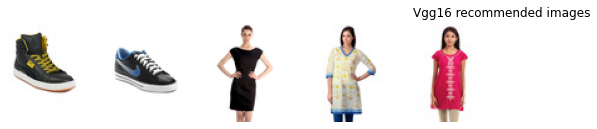

[(887, 1.0), (3303, 0.9778361), (1696, 0.97007036), (1018, 0.9565941), (714, 0.9496504)]


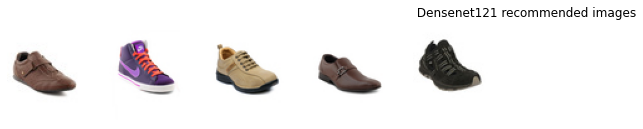

[(1886, 1.0), (2368, 0.96902084), (4855, 0.9640146), (1988, 0.96133393), (2306, 0.94077146)]


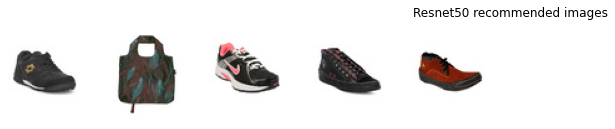

In [ ]:
chosen_img_indx = 0

recommendation = get_recommendations(chosen_img_indx, df, vgg_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Vgg16 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

recommendation = get_recommendations(chosen_img_indx, df, dn_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title(" Densenet121 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

recommendation = get_recommendations(chosen_img_indx, df, rn_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(DATASET_PATH + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Resnet50 recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

## **VGG**

In [ ]:
# From the OBTAINED RESULTS
#vgg16
TP = true_pos = 2
TN = true_neg = 3
FP = false_pos = 3
FN = false_neg = 3

Accuracy

number of examples correctly predicted / total number of examples  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c72ec21ef2505c2d376e96197637fc64f75e5891)

In [ ]:
results = {}
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.455


True Positive Rate

number of samples actually and predicted as  `Positive` / total number of samples actually `Positive`  
Also called **Sensitivity or Recall**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/64d5540cbadeb83f864d7a731b7ab43cccd0f353)


In [ ]:
# Sensitivity or Recall
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.400


Positive Predictive Value

number of samples actually and predicted as  `Positive` / total number of samples predicted as `Positive`  
Also called **Precision**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/699fcdb880b7f6a92742bc0845b8b60b59806a98)


In [ ]:
# Precision
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.400


## **Densenet**

In [ ]:
# from the OBTAINED RESULTS
# Densenet
TP = true_pos = 5
TN = true_neg = 0
FP = false_pos = 0
FN = false_neg = 0

In [ ]:
#Accuracy
results = {}
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  1.000


In [ ]:
# Sensitivity or Recall
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  1.000


In [ ]:
# Precision
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  1.000


## **Resent**

In [ ]:
# from the OBTAINED RESULTS
#Resnet
TP = true_pos = 4
TN = true_neg = 1
FP = false_pos = 0
FN = false_neg = 1

In [ ]:
results = {}
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.833


In [ ]:
# Sensitivity or Recall
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.800


In [ ]:
# Precision
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  1.000


## Visualization of Latent Space of Contents

Latent Space is a lower dimensional manifold of the high dimensional images where we expect all the instances of the dataset to lie in proximity.

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some visualizations to analyse the spread of the dataset. One is to look at the neighborhoods of different classes in the latent 2D plane
You can see different clusters generated by embeddings, which reinforces that features make sense. In the proceeding plots of different transfer learning model embbeding, it is possible to observe the separation by Category, and in more detail by subcategory.

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)

In [ ]:
tsne_results1 = tsne.fit_transform(df_embedding1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 14.292704582214355 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results1[:,0]
df['tsne-2d-two'] = tsne_results1[:,1]

**Visual Analysis of the results from Vgg16 model**

Here we have done clustering-based classification chart for the Master Categories: “Apparel”, 
“Accessories”,” Footwear”, “Personal Care” and “Free Items”. From the visualization it is clearly 
depicted that clothes and footwear have the most unique value and more collection of products to 
recommend. Vgg16 has provided least relevant results compared to other models

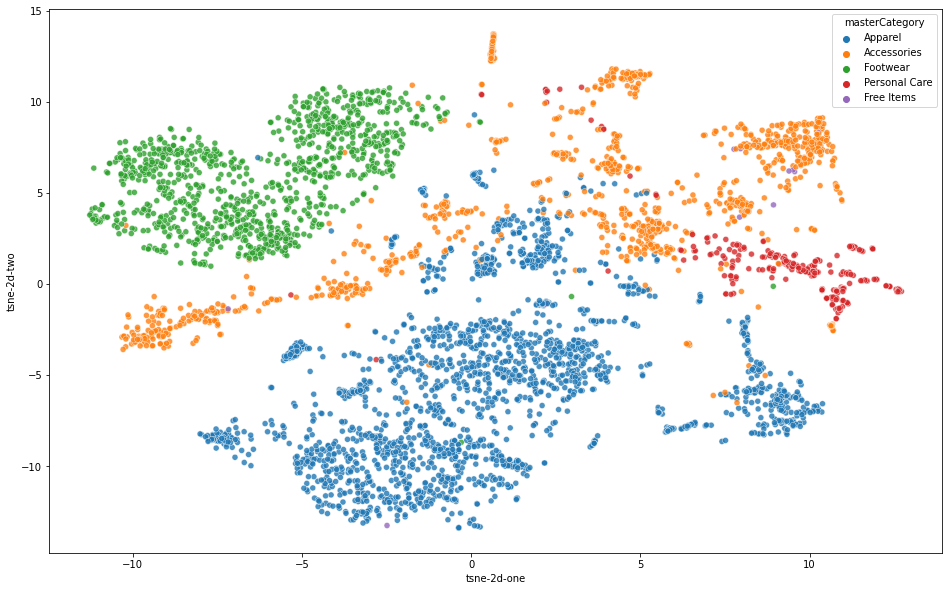

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

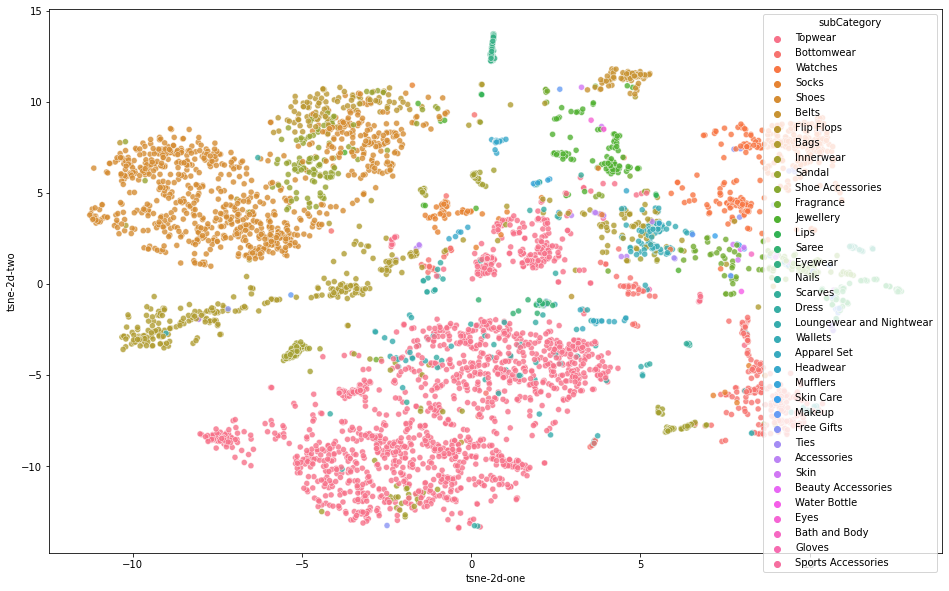

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results2 = tsne.fit_transform(df_embedding2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 31.172904014587402 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results2[:,0]
df['tsne-2d-two'] = tsne_results2[:,1]

**Visual Analysis of the results from Densenet121 model**

This model is so far the best pre trained model for recommending all categories of product. From the 
results the top 5 recommendation is noted to be spot on for every test input and the model is accurate 
and consistent.

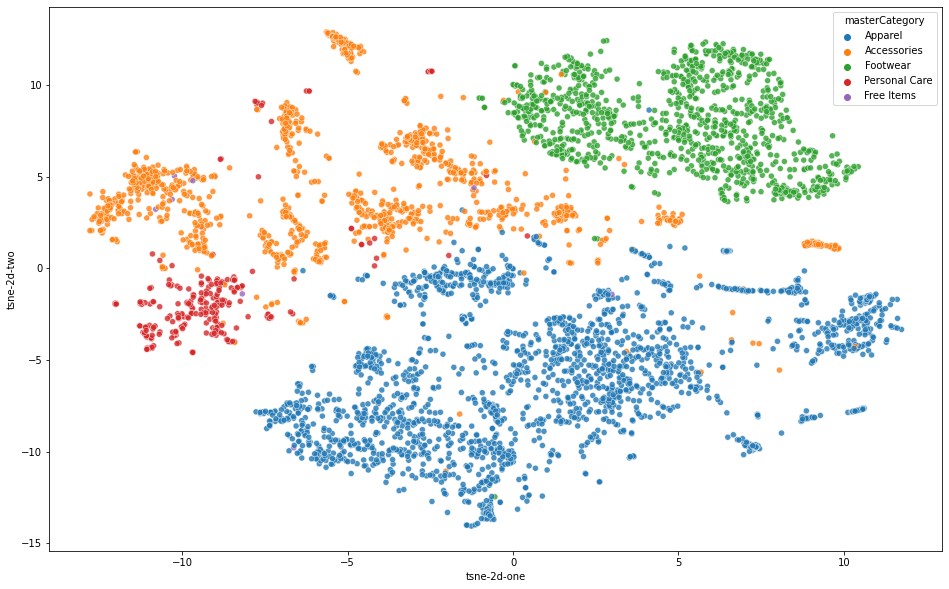

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

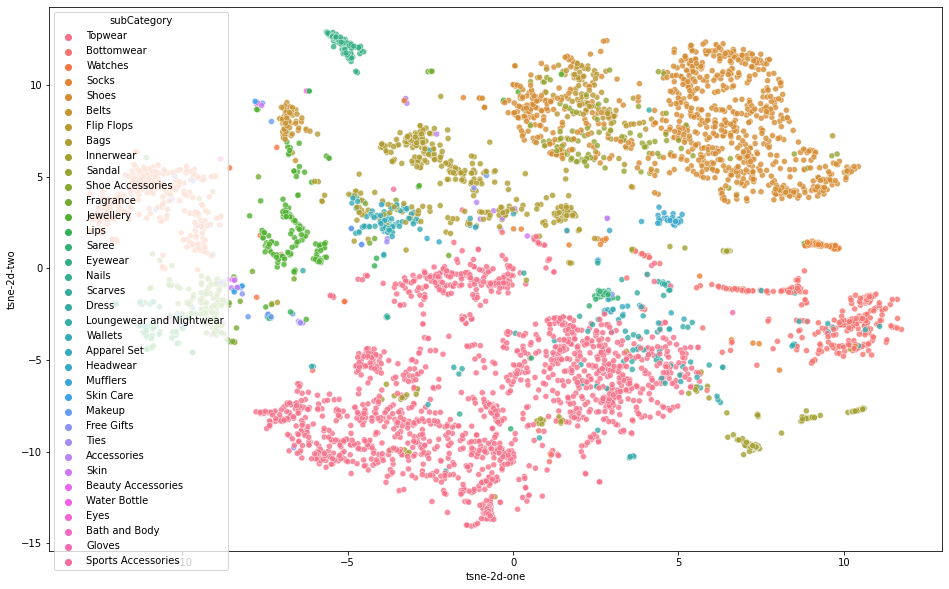

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

In [ ]:
tsne_results3 = tsne.fit_transform(df_embedding3)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 53.221503257751465 seconds


In [ ]:
df['tsne-2d-one'] = tsne_results3[:,0]
df['tsne-2d-two'] = tsne_results3[:,1]

## Visual Analysis of the results from Resnet50 model

This model is near accurate and provides better clustering results than Vgg16 model but both Resnet 
and Vgg16 were not constant over every other product category. i.e., the result in Vgg16 was 40 to 50 
percent accurate, densenet121 marked a 100 percent accuracy rate and Resnet50 provides 90 percent 
accurate results. 

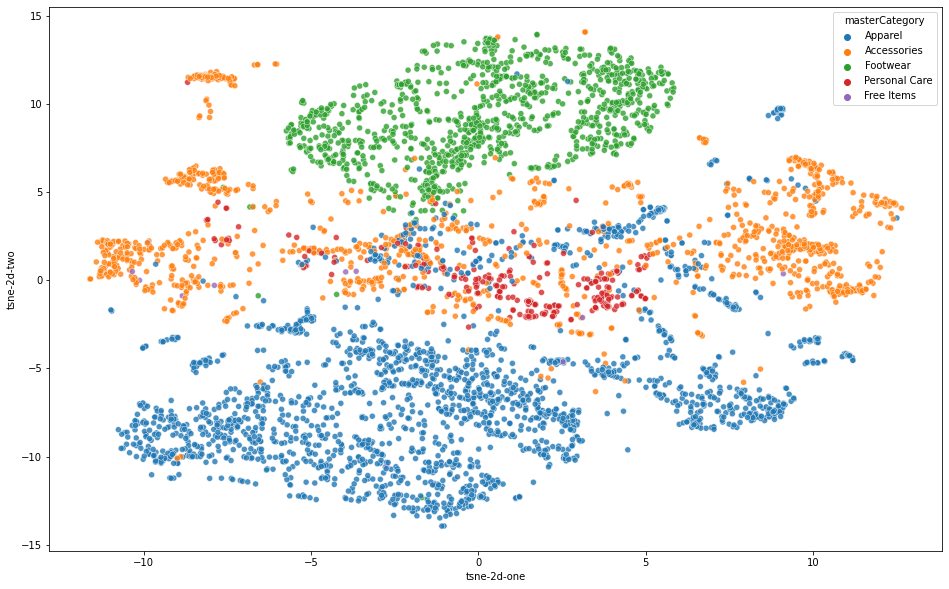

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

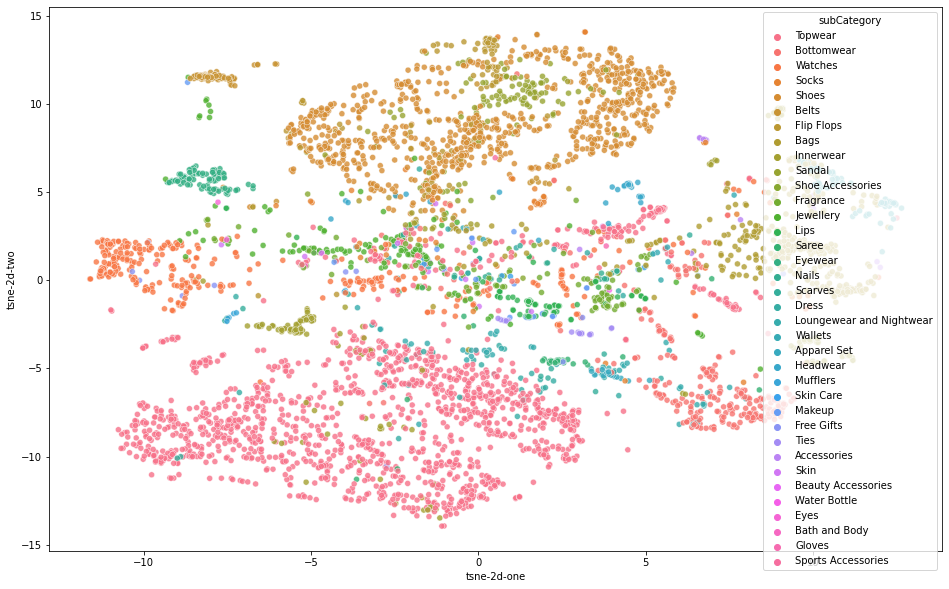

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

As we can see in the visualization of the latent space that the similar object have formed clusters while different objects are farther from each other in the latent space. For example, various types of topwears, watches, shoes or bags form respective clusters. While visually dissimilar objects e.g. topwears vs shoes have the highest distance in latent space. One thing is to be noted that since t-SNE embedding is stochastic, the results may appear slightly different every time it is re-run.
we visualized the latent space using t-SNE embedding. Then we embedded the data into Latent Space and visualized the results

In [ ]:
df_embedding1.to_csv('embedding_vgg.csv')
df_embedding2.to_csv('embedding_dn.csv')
df_embedding3.to_csv('embedding_rn.csv')